In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
# Set global parameters
plt.rcParams['figure.figsize'] = (8, 6)  # Figure size in inches (width, height)
# plt.rcParams['figure.dpi'] = 150  # Figure resolution in dots per inch
plt.rcParams['font.family'] = 'sans-serif'  # Font family
plt.rcParams['font.sans-serif'] = 'Fira Sans'
plt.rcParams['font.size'] = 16  # Font size
plt.rcParams['axes.labelsize'] = 10  # Font size of x and y labels
plt.rcParams['axes.titlesize'] = 18  # Font size of title
plt.rcParams['axes.grid'] = True  # Show grid by default
plt.rcParams['lines.linewidth'] = 6  # Line width
plt.rcParams['lines.markersize'] = 10  # Marker size
plt.rcParams['legend.fontsize'] = 16  # Font size of legend

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [3]:
#changing the working directory
os.chdir('/ada/ptmp/mpsd/shubsharma/HDNNP/mace/TaS2/remd/1H-TaS2/short_remd_coefficient_search/')

In [4]:
# !python3 remdsort.py input_remd.xml # sorting the replicas

In [5]:
# Reading all the outputs of the replicas
properties = {}
for file in os.listdir():
    if file.endswith("_simulation.out") & file.startswith("SRT"):
        idx = int(file.split('_')[1])
        data = np.loadtxt(file)
        properties[idx] = data
    else :
        continue
properties = {k: v for k, v in sorted(properties.items(), key=lambda item: item[0])}

# Deriving the constants for temperature spacing alorigthm

In [6]:
# Constants
kb = 8.617333262145e-5 # Boltzmann constant in eV/K 
Natoms = 27 # 3x3 1H-TaS2 supercell
Ndf = 3*Natoms-3 # degrees of freedom 

Using last 10ps of trajectory to compute ensemble averages

In [7]:
avg_potentials = np.array([np.mean(v[-10000:,6]) for k, v in properties.items()])
ensemble_temps = np.array([np.mean(v[-10000:,9]) for k, v in properties.items()])
observed_temps = np.array([np.mean(v[-10000:,3]) for k, v in properties.items()])
std_potentials = np.array([np.std(v[-10000:,6]) for k, v in properties.items()])/np.sqrt(Ndf)

In [8]:
print(f'Ensemble temperatures: {ensemble_temps}\n')
print(f'Observed temperatures: {observed_temps}')

Ensemble temperatures: [ 50.  53.  56.  59.  62.  65.  68.  71.  74.  77.  80.  83.  86.  89.
  92.  95.  98. 101. 104. 107. 110.]

Observed temperatures: [ 50.26108535  53.20330219  56.25668929  59.20290569  62.27423155
  65.17519428  67.91214192  71.20242199  74.01436144  76.92244628
  79.98700373  82.81899827  85.86762277  88.79839426  91.50337063
  94.81545514  97.99874072 100.58586705 103.75503566 106.71843229
 109.8139592 ]


Computing constants:

$\mu$ = $(B_{0} + B_{1}.T)N_{atoms}$ - $3.k_{B}.T$ \
$\sigma$ = $(D_{0} + D_{1}.T)\sqrt{N_{df}}$

Slope B_1: 0.0001261751193934205 eV/K, Intercept B_0: -152996.29528628185 eV, R-squared: 0.9999451545563839


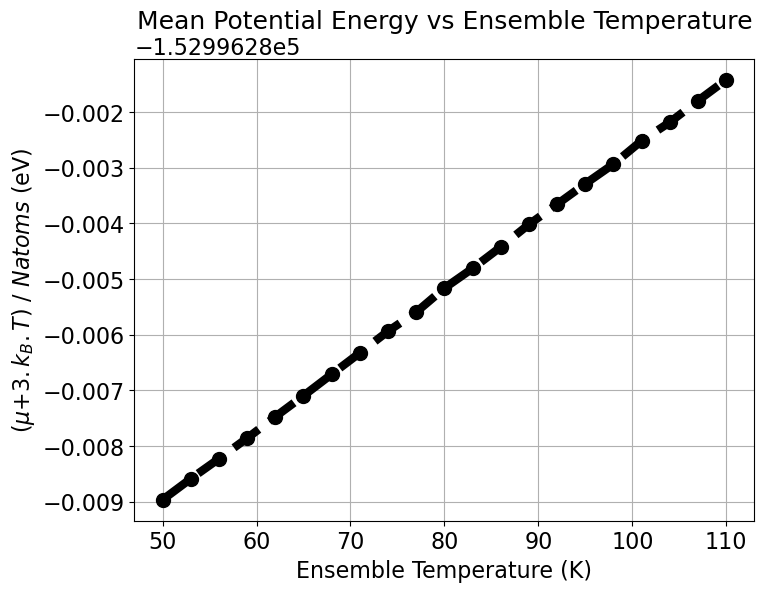

In [9]:
scaled_avg_potentials = (avg_potentials + 3 * kb * ensemble_temps)/Natoms 
plt.figure()
plt.title('Mean Potential Energy vs Ensemble Temperature')
plt.plot(ensemble_temps, scaled_avg_potentials ,'o--', color = 'k')
plt.xlabel('Ensemble Temperature (K)')
plt.ylabel(r'($\mu$+$3.k_{B}.T$) / $Natoms$ (eV)')
slope, intercept, r_value, p_value, std_err = linregress(ensemble_temps, scaled_avg_potentials)
B0, B1 = intercept, slope
print(f'Slope B_1: {slope} eV/K, Intercept B_0: {intercept} eV, R-squared: {r_value**2}')
plt.show()

Slope D_1: 5.800812914842667e-05 eV/K, Intercept D_0: 9.350154882901713e-05 eV, R-squared: 0.998153170144406


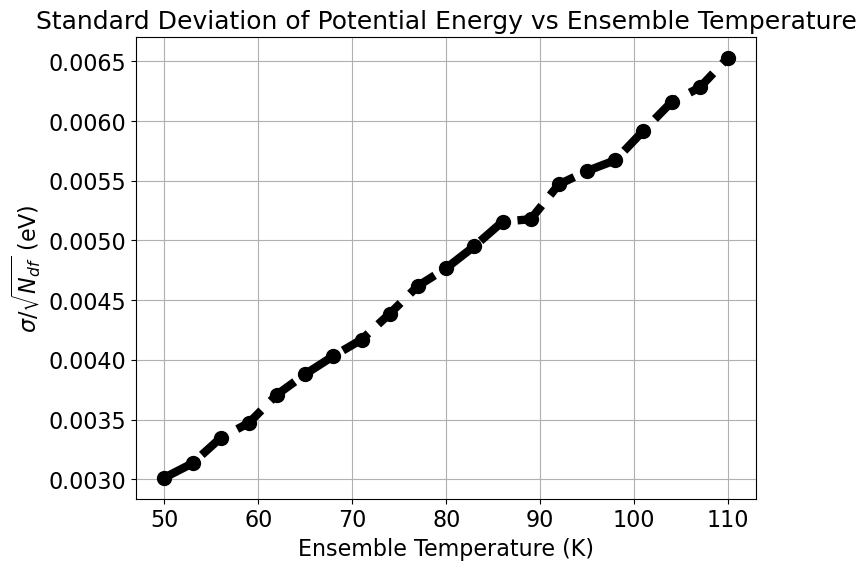

In [10]:
plt.figure()
plt.title('Standard Deviation of Potential Energy vs Ensemble Temperature')
plt.plot(ensemble_temps, std_potentials ,'o--', color = 'k')
plt.xlabel('Ensemble Temperature (K)')
plt.ylabel(r'$\sigma$/$\sqrt{N_{df}}$ (eV)')
slope, intercept, r_value, p_value, std_err = linregress(ensemble_temps, std_potentials)
D0, D1 = intercept, slope
print(f'Slope D_1: {slope} eV/K, Intercept D_0: {intercept} eV, R-squared: {r_value**2}')
plt.show()


# Acceptance probability

Mean and std. deviation for difference in potential energy

$\mu_{12} = B_{1}(T_{2}-T_{1})N_{atoms} - 3k_{B}(T_{2}-T_{1})$ \
$\sigma_{12} = D_{1}(T_{2}-T_{1})\sqrt{N_{df}}$

In [11]:
import numpy as np
from scipy.special import erf
from scipy.optimize import root_scalar

class ComputeTempSpacings:
    def __init__(self, B0, B1, D0, D1, T1, Natoms, Ndf, kb):
        self.B0 = B0
        self.B1 = B1
        self.D0 = D0
        self.D1 = D1
        self.T1 = T1
        self.Natoms = Natoms
        self.Ndf = Ndf
        self.kb = kb

    def mu(self, T2):
        return self.B1 * (T2 - self.T1) * self.Natoms - 3 * self.kb * (T2 - self.T1)

    def sigma(self, T2):
        return self.D1 * np.sqrt(self.Ndf) * (T2 - self.T1)

    def C(self, T2):
        return 1/(self.kb * T2) - 1/(self.kb * self.T1)

    def prob(self, T2):
        mu_val = self.mu(T2)
        sigma_val = self.sigma(T2)
        C_val = self.C(T2)
        
        # for numerical stability we use log probabilities
        log_one = np.log(0.5) + np.log1p(erf(-mu_val / (np.sqrt(2) * sigma_val)))
        log_second = np.log(0.5) + C_val * mu_val + (C_val**2 * sigma_val**2) / 2
        log_third = np.log1p(erf((mu_val + C_val * sigma_val**2) / np.sqrt(2 * sigma_val**2)))
        
        log_prob = np.logaddexp(log_one, log_second + log_third)
        return np.exp(log_prob)

    def find_T2(self, target_prob, T2_guess_low, T2_guess_high):
        def equation(T2):
            return self.prob(T2) - target_prob
        
        solution = root_scalar(equation, bracket=[T2_guess_low, T2_guess_high], method='brentq')
        
        if solution.converged:
            return solution.root
        else:
            raise ValueError("Solution did not converge")



In [13]:
Natoms = 1404 # This need to be changed for required system; here (6xroot13) 1T-TaS2 supercell
Ndf = 3*Natoms-3 # degrees of freedom 
B0, B1, D0, D1 = B0, B1, D0, D1
T1, T_final = 50, 150 
target_prob = 0.25
T2 = 0 # just a placeholder

T1s, T2s, delta_Ts = [], [], []

print(f"Total number of atoms: {Natoms}")
print(f"Degrees of freedom: {Ndf}")
print(f"Values of constants: B0={B0} eV, B1={B1} eV/K, D0={D0} eV, D1={D1} eV/K")
print(f"Inital temperature: {T1} K\tFinal temperature: {T_final} K")
print(f"Target acceptance probability for swapping (T1-T2): {target_prob}\n")

Total number of atoms: 1404
Degrees of freedom: 4209
Values of constants: B0=-152996.29528628185 eV, B1=0.0001261751193934205 eV/K, D0=9.350154882901713e-05 eV, D1=5.800812914842667e-05 eV/K
Inital temperature: 50 K	Final temperature: 150 K
Target acceptance probability for swapping (T1-T2): 0.25



In [14]:
os.chdir('/ada/ptmp/mpsd/shubsharma/HDNNP/mace/TaS2/remd/1T-TaS2/classical_remd/')
print("Starting temperature spacing search...")
with open('temperature_spacing_search.log', 'w') as f:
    f.write(f"Total number of atoms: {Natoms}\n")
    f.write(f"Degrees of freedom: {Ndf}\n")
    f.write(f"Values of constants: B0={B0} eV, B1={B1} eV/K, D0={D0} eV, D1={D1} eV/K\n")
    f.write(f"Inital temperature: {T1} K\tFinal temperature: {T_final} K\n")
    f.write(f"Target acceptance probability for swapping (T1-T2): {target_prob}\n\n")
    
    while T2 < T_final:
        model = ComputeTempSpacings(B0, B1, D0, D1, T1, Natoms, Ndf, kb)
        try:
            T2 = model.find_T2(target_prob, T1, 1000)
            T1s.append(T1)
            T2s.append(T2)
            delta_Ts.append(T2 - T1)
            print(f"Acceptance probability: {model.prob(T2):.2f}\tT1: {T1:.2f} K\tT2: {T2:.2f} K\tDelta T: {T2 - T1:.2f} K")
            f.write(f"Acceptance probability: {model.prob(T2):.2f}\tT1: {T1:.2f} K\tT2: {T2:.2f} K\tDelta T: {T2 - T1:.2f} K\n")
        except ValueError as e:
            print(e)
        T1 = T2

Starting temperature spacing search...
Acceptance probability: 0.25	T1: 50.00 K	T2: 51.32 K	Delta T: 1.32 K
Acceptance probability: 0.25	T1: 51.32 K	T2: 52.67 K	Delta T: 1.35 K
Acceptance probability: 0.25	T1: 52.67 K	T2: 54.05 K	Delta T: 1.39 K
Acceptance probability: 0.25	T1: 54.05 K	T2: 55.48 K	Delta T: 1.42 K
Acceptance probability: 0.25	T1: 55.48 K	T2: 56.94 K	Delta T: 1.46 K
Acceptance probability: 0.25	T1: 56.94 K	T2: 58.44 K	Delta T: 1.50 K
Acceptance probability: 0.25	T1: 58.44 K	T2: 59.98 K	Delta T: 1.54 K
Acceptance probability: 0.25	T1: 59.98 K	T2: 61.56 K	Delta T: 1.58 K
Acceptance probability: 0.25	T1: 61.56 K	T2: 63.18 K	Delta T: 1.62 K
Acceptance probability: 0.25	T1: 63.18 K	T2: 64.84 K	Delta T: 1.66 K
Acceptance probability: 0.25	T1: 64.84 K	T2: 66.55 K	Delta T: 1.71 K
Acceptance probability: 0.25	T1: 66.55 K	T2: 68.30 K	Delta T: 1.75 K
Acceptance probability: 0.25	T1: 68.30 K	T2: 70.10 K	Delta T: 1.80 K
Acceptance probability: 0.25	T1: 70.10 K	T2: 71.94 K	Delta T: 1.

/tmp/ipykernel_15522/1430485309.py:31: RuntimeWarning: invalid value encountered in double_scalars
  log_one = np.log(0.5) + np.log1p(erf(-mu_val / (np.sqrt(2) * sigma_val)))
/tmp/ipykernel_15522/1430485309.py:33: RuntimeWarning: invalid value encountered in double_scalars
  log_third = np.log1p(erf((mu_val + C_val * sigma_val**2) / np.sqrt(2 * sigma_val**2)))
/tmp/ipykernel_15522/1430485309.py:35: RuntimeWarning: invalid value encountered in logaddexp
  log_prob = np.logaddexp(log_one, log_second + log_third)
/tmp/ipykernel_15522/1430485309.py:31: RuntimeWarning: divide by zero encountered in log1p
  log_one = np.log(0.5) + np.log1p(erf(-mu_val / (np.sqrt(2) * sigma_val)))
/tmp/ipykernel_15522/1430485309.py:33: RuntimeWarning: divide by zero encountered in log1p
  log_third = np.log1p(erf((mu_val + C_val * sigma_val**2) / np.sqrt(2 * sigma_val**2)))


In [15]:
print(np.asarray(T2s).shape)

(43,)
